# Semester Project - Continuous time paradigm in Digital Signal Processing investigation

Continuous-Time Digital Signal Processing is a signal processing paradigm that allows the discretization of a signal, working only by means of amplitude quantization. The discrete signal remains continuous in time in the digital domain, allowing a number of advantages from a digital processing point of view, such as removed aliasing phenomena and reduction of quantization error. It has been shown how this method can be achieved with “event-driven” control systems using level-crossing sampling, amplitude quantization and input signal decomposition.

This notebook contains the complete analysis done throughout the semester, following these main steps:

1. **Continuous time simulation with oversampling**: a simulation of continuous time signals with an oversampling approach and comparison of the spectral effects of quantization only and quantization+sampling
2. **Theoretical quantization approach**: following the derivation present in the article
3. **Amplitude sampler**
4. **Binary wave and FIR reconstruction**




⚠️Before starting⚠️
Make sure you have installed all the following packages and you have all the necessary Python files contained in the repository!

In [2]:
# packages
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

from scipy import signal, fft
from scipy.optimize import brentq
from scipy.signal import find_peaks


In [3]:
# external function files
import functions, filters_func
import utils
from functions import signals_ex
from functions import amplitude_sampler

In [4]:
%load_ext autoreload
%autoreload 2

## 1. Continuous time simulation with oversampling

In oder to show the effect of combined quantizatio and sampling on arbitrary signal, one must first try recreate a signal that is close to continuos time as possible.
The easiest, yet not highly efficient way to do this, is to oversample the signal with an extrimely high sampling frequency.

Let's try this first with an easy signal: a sinusoidal wave.
We start by defining the time vector given a finite duration and the choosen sampling frequency

In [138]:
# frequency settings
f_wave = 1000 # Hz
fsmp_ct = 120000
fsmp_1 = 44100;
# duration
n_periods = 1000;
duration= n_periods*1/f_wave
xlimit = 2/f_wave

In [139]:
print("Frequency of the sinusoid: ", f_wave, "Hz")
print("Period of the sinusoid: ", 1/f_wave, "s")
print("Over-Sampling frequency: ", fsmp_ct, "Hz")
print("Duration of the sinusoid: ", duration, "s")

Frequency of the sinusoid:  1000 Hz
Period of the sinusoid:  0.001 s
Over-Sampling frequency:  120000 Hz
Duration of the sinusoid:  1.0 s


In [140]:
# continuous time wave
t_ct = functions.time_vector(fsmp_ct, duration)
s = signals_ex(t_ct, f_wave)
x_ct = s.cosine(amp = 0.8)

# sampled wave
t_smp1 = functions.time_vector(fsmp_1, duration) # continuous time vector
s = signals_ex(t_smp1, f_wave)
x_smp1= s.cosine(amp = 0.8)

print("Length of continuous time signal : ", len(t_ct), len(x_ct))
print("Length of sampled signal: ", len(t_smp1), len(x_smp1))

Length of continuous time signal :  120000 120000
Length of sampled signal:  44100 44100


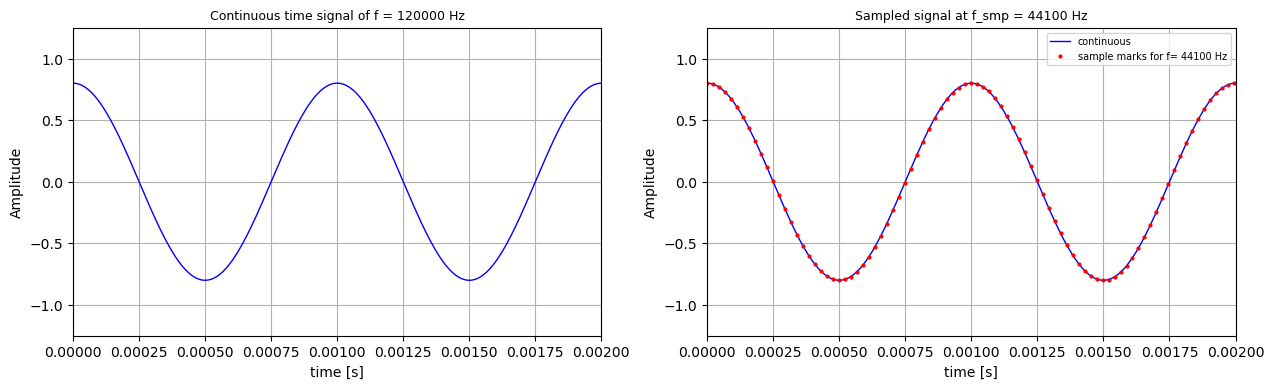

In [141]:
fig = plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous signal', col='b')
plt.title('Continuous time signal of f = %d Hz' %(fsmp_ct),fontsize = 9)

plt.subplot(1,2,2)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous', col= 'b')
plt.plot(t_smp1, x_smp1,'o',color='red',markersize=2, label= 'sample marks for f= %d Hz' %(fsmp_1))
plt.title('Sampled signal at f_smp = %d Hz' %(fsmp_1),fontsize = 9)
plt.legend(prop={'size': 7})

#### Quantization of CT signal


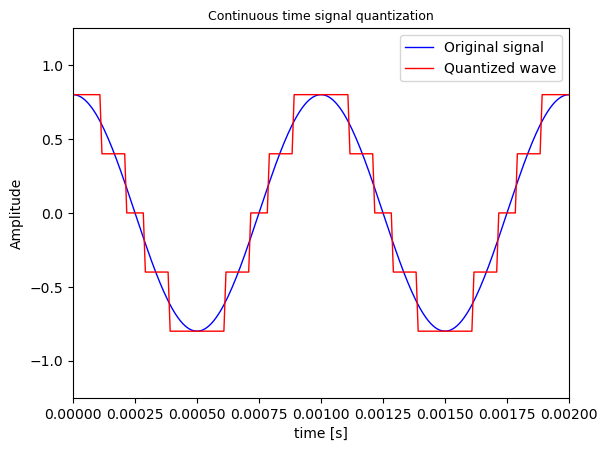

In [142]:
q = functions.quantizer(5)
x_q = q.quantize(x_ct)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='Original signal', col='b')
utils.plot_wave(t_ct, x_q, xlimit, ylim=1.25,label='Quantized wave',col='r' )
plt.title('Continuous time signal quantization',fontsize = 9)
plt.legend()

#### Quantization + sampling

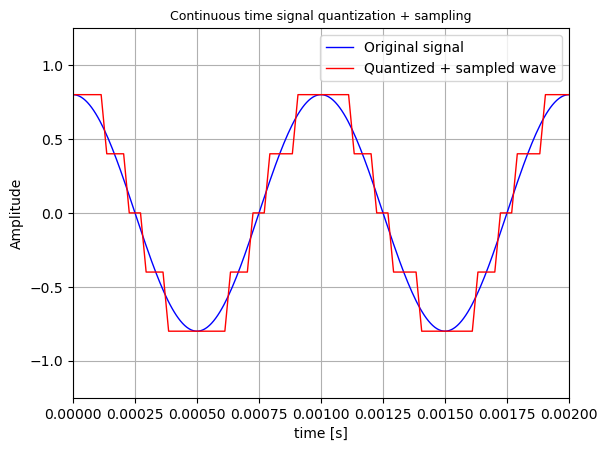

In [143]:
q = functions.quantizer(5)
x_q_smp1 = q.quantize(x_smp1)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='Original signal', col='b')
utils.plot_wave(t_smp1, x_q_smp1, xlimit, ylim=1.25,label='Quantized + sampled wave',col='r' )
plt.title('Continuous time signal quantization + sampling',fontsize = 9)
plt.grid()
plt.legend()


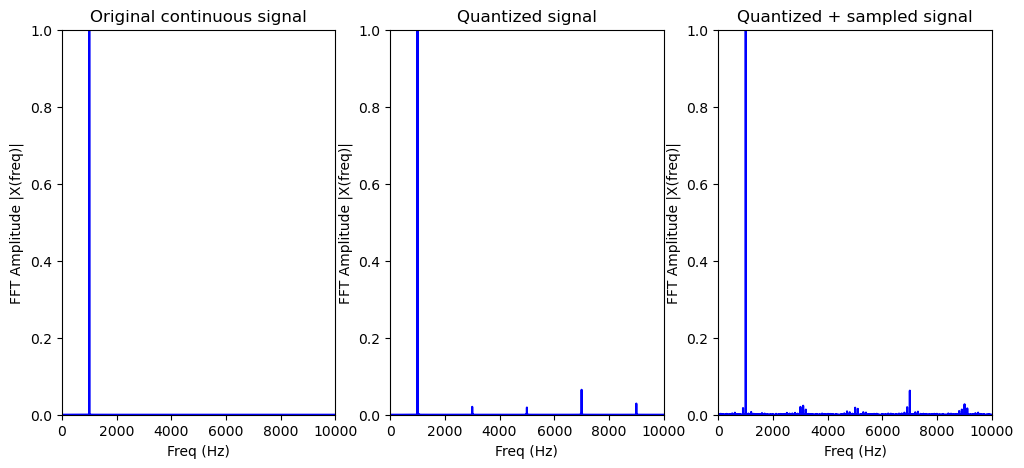

In [144]:
freq_ct, X_ct = utils.fourier_analysis(x_ct, fsmp_ct)
freq_q, X_q = utils.fourier_analysis(x_q, fsmp_ct)
freq_q_smp1, X_q_smp1 = utils.fourier_analysis(q.quantize(x_smp1), fsmp_1)

plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot(freq_ct, X_ct, freq_lim=10000, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot(freq_q, X_q, freq_lim=10000, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot(freq_q_smp1, X_q_smp1, freq_lim=10000, title="Quantized + sampled signal")

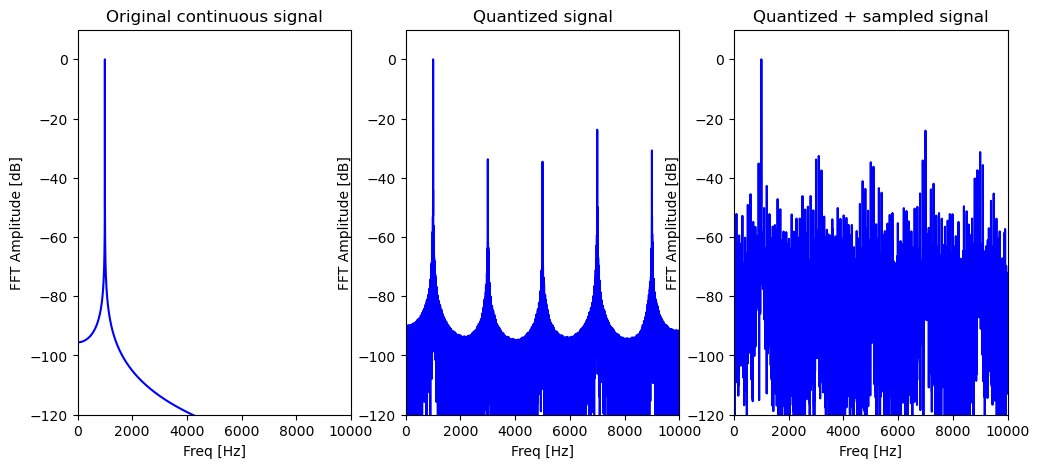

In [145]:
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot_db(freq_ct, X_ct, freq_lim=10000, ylim=-120, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot_db(freq_q, X_q, freq_lim=10000, ylim= -120, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot_db(freq_q_smp1, X_q_smp1, freq_lim=10000, ylim=-120,title="Quantized + sampled signal")

## 2. Theoretical Quantization

The oversampling method is helpful to visualize the spectral effects of sampling on a quantized signal, but it is a very computationally heavy task. The higher the frequency of our signal is, the higher the sampling frequency will have to be in order to first satisfy the Nyquist criterion, and secondly to achieve a sufficient number of points to mimic the continuous time behaviour, i.e. a smooth and continuous curve. The reference article presents a theoretical approach to perform a CT quantization to a specific category of deterministic symmetric inputs, of which we will consider the simple case of a symmetric sinusoidal imput:

The input signal must have a maximum amplitude that mantains the odd symmetry in the transfer characteristic. In this case, using a 3 bit mid-tread quantizer normalized to $[-1,+1]$, this can be achieved by imposing an upper bound to the amplitude as:
$x_{max} = \left(1 - \frac{1}{2^N} \right)$

The output of the quantizer for this class of inputs can be rewritten as a one-sided Fourier sum:
\begin{math}
\large q( t) =  \sum_{n=1}^{\inf} c(n) sin(2\pi \frac{1}{T}\cdot n \cdot t)
\end{math}
where the Fourier coefficients are found to be given by:
\begin{math}
\large c(n) = \frac{4\Delta}{\pi n} sin\left(\frac{\pi}{2}n\right)\sum_{n=1}^{N_{steps}} sin ( d_i \cdot \pi \cdot n )
\end{math}

In the previous equation, we have a few more elements that can be defined according to a specific formula:
- the **number of steps** $N_{steps}$ above 0 utilized in the first half-cycle: $ N_{ steps} = min \left( 2^{N-1}, int \left( \frac{A + 0.5\Delta}{\Delta}\right) \right) $
- the **duty cicle** $d_i$, related to the duration of time that the input signal spends above the ith positive quantization level boundary when looking at the first half cycle of the input, found as $ d_i = \frac{1}{2} - \frac{1}{\pi} \text{sin}^{-1} \left( \frac{(2i - 1)\Delta}{2A}\right) $

In [52]:
class theory_class:
    def __init__(self, N):
        self.NBits = N
    def x_max(self):
        xmax = 1 - 1 / (2 ** self.Nbits)
        return xmax
    def step_size(self):
        delta_step = (2) / (2 ** (self.NBits))  # Assuming step normalized to 1
        return delta_step
    def amp_f(self, delta_step):
        amp = (2 ** (self.NBits - 1) - 1) * delta_step
        return amp
    def num_steps(self,amp,delta):
        a = 2 ** (self.NBits- 1) - 1
        b = int((amp + 0.5 * delta) / delta)
        N = np.minimum(a, b)
        return N

In [49]:
def duty(D, amp, n):
    d = np.zeros(n+1)
    for i in range(1,n+1):
        d[i] = 1/2 - (1/np.pi)*np.arcsin((2*i-1)*D/(2*amp))
    return d

def threshold(n, D):
    x = np.zeros(n+1)
    for i in range(1,n+1):
        x[i] = D*((2*i-1)/2)
    return x

In [53]:
f = 1000
f_smp = f*100
n_periods=1000
dur=n_periods*1/f
T=1/f
T_smp = 1/f_smp

t= np.linspace(0,dur, int(np.ceil(dur/T_smp)))
sin_wave = np.sin(2*np.pi*f*t)

print("Duration of the signal is: ", dur, "s")
print("The period of the signal is: ", T, "s")
print("Length of the time vector is: ", len(t), "samples")

Duration of the signal is:  1.0 s
The period of the signal is:  0.001 s
Length of the time vector is:  100000 samples


In [56]:
N_qbits = 3;

th  = theory_class(N_qbits)

delta = th.step_size()
A = th.amp_f(delta)
N_steps = th.num_steps(A, delta)

print("The max amplitude of the signal is: ", A)
print("The size of the step is: ", delta)
print("The number of steps is: ", N_steps)

The max amplitude of the signal is:  0.75
The size of the step is:  0.25
The number of steps is:  3


In [57]:
dc = duty(delta, A, N_steps)[1:]
print("Lenght of duty cicles: {}".format(dc))

x_t = threshold(N_steps, delta)[1:]
print("Height of thresholds: {}".format(x_t))

Lenght of duty cicles: [0.44669962 0.33333333 0.1864295 ]
Height of thresholds: [0.125 0.375 0.625]


In [58]:
# Fourier coefficients
def c_n(D, nsteps, dc, n_idx):
    cn = 0
    for i in range(1,nsteps+1):
        tmp = (4*D)/(np.pi*n_idx)*np.sin(np.pi*n_idx/2)*np.sin(np.pi*n_idx*dc[i-1])
        cn = cn + tmp
        #print("Nsteps: {} - tmp: {} - Cn: {}".format(i, tmp, cn))
    return cn

# Fourier series
def q_out (D, nsteps, dc, T, t, k):
    q_out = np.zeros(len(t))
    for i in range(1, k):
        tmp = c_n(D, nsteps, dc, i)*np.sin(2*np.pi*i/T*t)
        q_out = q_out + tmp
    return q_out

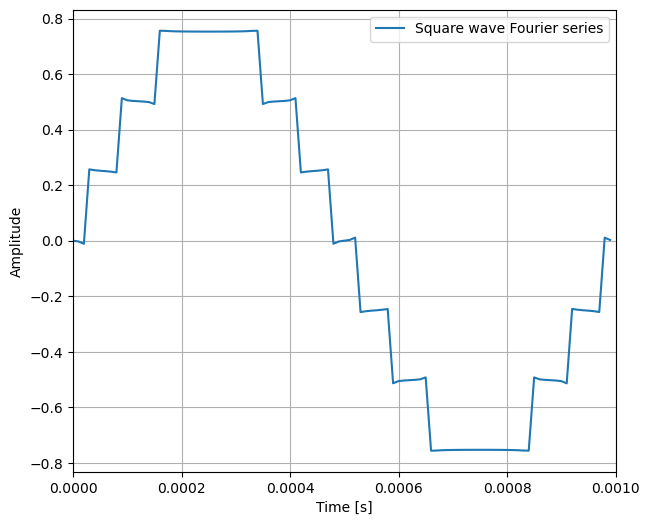

In [72]:
k = 100
c_n(delta, N_steps, dc, 1)
q_th = q_out(delta, N_steps, dc, T, t[0:100], k)

plt.figure(figsize=(7,6))
plt.plot(t[0:100], q_th[0:100], label = 'Square wave Fourier series')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.legend()
plt.xlim(0,T)
plt.grid()

q_th = np.tile(q_th, n_periods)

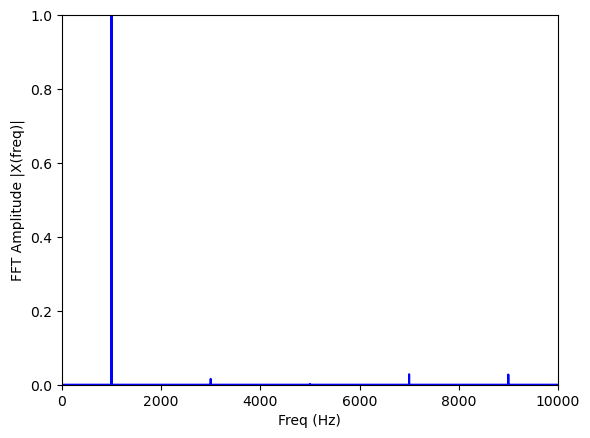

In [75]:
freq_th, X_th = utils.fourier_analysis(q_th, f_smp)
utils.fourier_plot(freq_th, X_th, freq_lim = 10000, title= "")

## 3. Amplitude sampler
The oversampling method is helpful to visualize the spectral effects of sampling on a quantized signal, but it is a very computationally heavy task. The higher the frequency of our signal is, the higher the sampling frequency will have to be in order to first satisfy the nyquist criterion, and secondly to achieve a sufficient number of points to mimic the continuous time behaviour, i.e. a smooth and continuous curve.

**explain the problem with time precision of the crossing instants even with high oversampling**

In this section, we explore a new method that does not involve oversampling, but it is purely based on the principle of amplitude sampling. This is not only helpful for the matter of computational costs, but it is also very efficient as it is similar to an event-based process.


**Explain amplitude sampler**

In [5]:
T = 1
t_range = np.linspace(0,T,1000)
q = functions.quantizer(5)

# transitions and bins
t, q_idx = amplitude_sampler(functions.test_func, T, q)
bin_step = q.qvalue(q_idx) #find the step value of each bin

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))
print('Bins step value: {}'.format(bin_step))

Transition instants: [0.         0.1115502  0.17861206 0.2380546  0.30511647 0.52821686
 0.59527873 0.65472127 0.72178314 0.94488353]
Bins index: [4 3 2 1 0 1 2 3 4 3]
Bins step value: [ 0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8  0.4]


The following tests show that the transition points are independent of the initial density of the grid. As long as the grid is not too sparse, we are able to obtain the crossing instants efficiently with fewer points

In [6]:
print(" 10000 points per period grid: {}".format(amplitude_sampler(functions.test_func, T, q, gd=10000)[0][0:5]))
print(" 100 points per period grid: {}".format(amplitude_sampler(functions.test_func, T, q, gd=100)[0][0:5]))

 10000 points per period grid: [0.         0.1115502  0.17861206 0.2380546  0.30511647]
 100 points per period grid: [0.         0.1115502  0.17861206 0.2380546  0.30511647]


In [162]:
try:
    amplitude_sampler(functions.test_func, T, q, gd=10)[0]
except AssertionError:
    print('crossing more than one level')

crossing more than one level


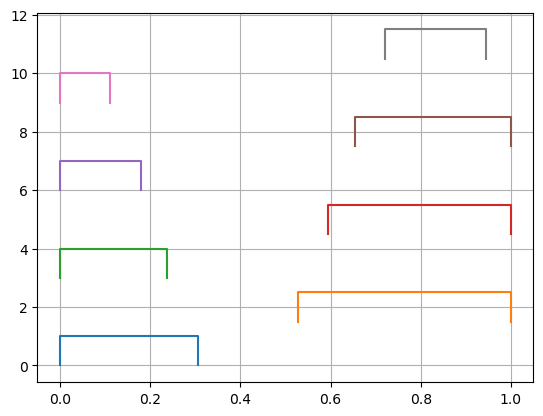

In [11]:
functions.decompose(t, q_idx, T)
n = 0

for p in functions.decompose(t, q_idx, T):
    plt.plot([p[0], p[0], p[1], p[1]], [n, n + 1, n + 1, n])
    n += 1.5

plt.grid()
plt.show()

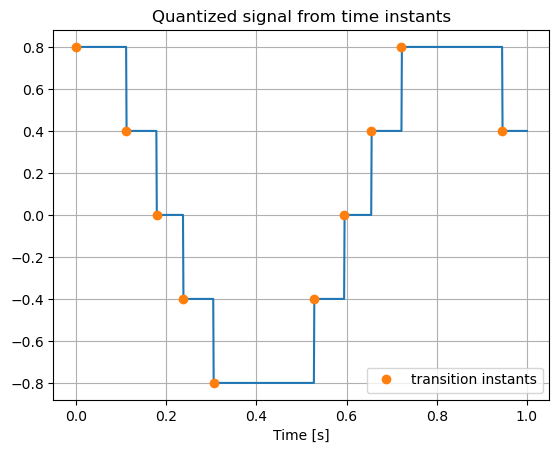

In [7]:
pulse_times = functions.decompose(t, q_idx, T)
functions.plot_decomposition(functions.decompose(t, q_idx, T), q)
plt.plot(t, bin_step, 'o', label='transition instants')
plt.title("Quantized signal from time instants")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()

Starting from the previous decomposition, we can recostruct the signal using a Fourier series specifically taylored for our pulses functions. Indeed, knowing the crossing instants at the beginning and end of the pulse, namely $t_0$ and $t_1$, and assuming a period of $T$, we find the Fourier series to be as follows:

\begin{math}
\Large f ( x ) =  \sum_n c_{n} e^{j 2 \pi \frac{n}{T} x }
\end{math}


with coefficients $C_n$:
\begin{math}
\Large c_n = \frac{1}{\pi n} e^{-j 2 \pi n \frac{t}{T} \frac{t_{0} + t_{1}}{2} } \text{sin} ( 2 \pi n \frac{t}{T} \frac{t_{1} - t_{0}}{2} )

\end{math}

In [8]:
# Fourier Series
def FS(n, t0,t1, T, x, delta):
    F=0
    for i in range(1,n):
        c = 1/(np.pi*i) * (np.exp(-1j*2*np.pi*i/T*(t0+t1)/2)*np.sin(2*np.pi*i/T*(t1-t0)/2))
        F_tmp  = delta * c*np.exp(1j*2*np.pi*i*x/T)
        F = F + F_tmp
    return F

C:\Users\Utente\anaconda3\envs\SP_pycharm\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Fourier series reconstruction')

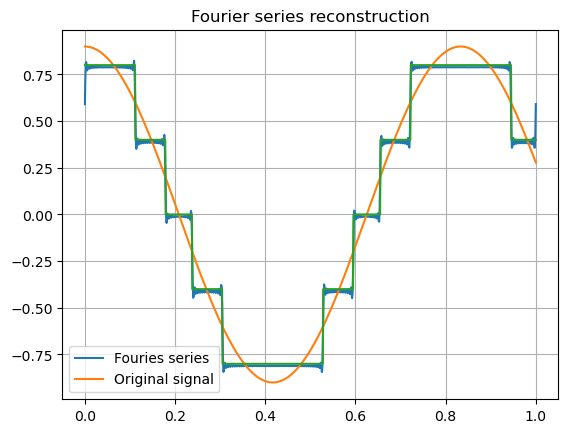

In [17]:
FS_complete = 0
x = np.linspace(0, T, 1000) #time vector
pulse_times= functions.decompose(t, q_idx, T)

for i in range(len(pulse_times)):
    F_tmp = FS(200, pulse_times[i][0], pulse_times[i][1],T, x, q.step*2)
    FS_complete = FS_complete + F_tmp

plt.plot(x, FS_complete + 0.1, label="Fouries series")
plt.plot(x, functions.test_func(x), label= "Original signal")
functions.plot_decomposition(functions.decompose(t, q_idx, T), q)
plt.legend()
plt.grid()
plt.title("Fourier series reconstruction")


TO DO
- check parte 2
- spiegare meglio parte 3
- aggiungere parte 4

- aggiustare ciascun singolo notebook con più esempi